# Clinical Evaluation

The first two sheets include clinical annotations of all the patients for disease-free survival/recurrence and for overall survival. 

To perform clinical evaluation specific output format should be obtained!
\
These are the columns and their order:
\
Some new columns need to be created and added, e.g. (DISEASE FREE FOR MORE THAN 5 YEARS becomes 1) IFF (DFS_STATUS IS 'DiseaseFree'
 AND DFS_MONTHS IS >60 MONTHS)

In [38]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer

plt.style.use('ggplot')
sns.set_theme()
plt.rcParams["figure.figsize"] = (12, 4)

df_clinical_dfs = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='ALL BREAST TCGA-PANCA DFS')
df_clinical_dfs.head()

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971


In [3]:
df_clinical_os = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='ALL BREAST TCGA PANCA OS')
print(df_clinical_os.shape)
df_clinical_os.head()

(1084, 4)


,Study ID,Patient ID,OS_STATUS,OS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,LIVING,133.050597
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,LIVING,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,LIVING,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,LIVING,47.604958
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,LIVING,11.440971


In [4]:
df_clinical_out_cols = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='EXAMPLE output - OS DFS SUBTYPE').columns
df_clinical_out_cols = df_clinical_out_cols[:-2]
df_clinical_out_cols

Index(['Patient ID', 'DFS_STATUS', 'DFS_MONTHS', 'RECURRED BEFORE 5 YEARS',
       'RECURRED AFTER FIVE YEARS', 'DISEASE FREE FOR LESS THAN 5 YEARS',
       'DISEASE FREE FOR MORE THAN 5 YEARS', 'OS_STATUS', 'OS_MONTHS',
       'DECEASED WITHIN 5 YEARS', 'SUBTYPE', 'IS LUMA',
       'TRAINING OR TESTING?'],
      dtype='object')

In [5]:
with open('../data/dataset_multilabel.pkl', 'rb') as file:
    df_multi = pickle.load(file)

print(df_multi.shape)
df_multi.head()

(1053, 25159)


,tcga_id,expert_PAM50_subtype,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,ZYX,ZZEF1,ZZZ3,Subtype-from Parker centroids,MaxCorr,Basal,Her2,LumA,LumB,Normal
0,TCGA-3C-AAAU,LumA,57898,67829,134,1697402,44314,1737,568,0,...,1054121,557596,409660,LumA,0.373445,-0.439712,-0.256279,0.373445,0.179928,-0.073517
1,TCGA-3C-AALI,Her2,52146,65152,1361,1403901,36852,1636,1357,41,...,1041074,247545,88163,Her2,0.647827,-0.191357,0.647827,-0.112797,0.247731,-0.322065
2,TCGA-3C-AALJ,LumB,52172,29356,510,989281,30378,282,1974,119,...,613785,110466,68745,LumB,0.357503,-0.409172,-0.015318,0.144970,0.357503,-0.276062
3,TCGA-3C-AALK,LumA,50517,43436,287,2674831,69374,816,2084,172,...,1397623,196615,206477,LumA,0.666747,-0.419544,-0.316495,0.666747,-0.307467,0.458535
4,TCGA-4H-AAAK,LumA,66433,66229,192,2279532,56667,1603,2425,246,...,970767,199472,246179,LumA,0.556303,-0.275390,-0.328403,0.556303,-0.437599,0.503962


In [6]:
# Merge the dataframes based on the 'ID' column
merged_df = pd.merge(df_clinical_dfs, df_clinical_os, on=['Patient ID', 'Study ID'])
merged_df

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444,LIVING,133.050597
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790,LIVING,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743,LIVING,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN,LIVING,47.604958
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971,LIVING,11.440971
...,...,...,...,...,...,...
1079,brca_tcga_pan_can_atlas_2018,TCGA-WT-AB44,DiseaseFree,29.029819,LIVING,29.029819
1080,brca_tcga_pan_can_atlas_2018,TCGA-XX-A899,DiseaseFree,15.353256,LIVING,15.353256
1081,brca_tcga_pan_can_atlas_2018,TCGA-XX-A89A,DiseaseFree,16.043660,LIVING,16.043660
1082,brca_tcga_pan_can_atlas_2018,TCGA-Z7-A8R5,NaN,NaN,LIVING,108.064569


In [7]:
merged_df['OS_STATUS'].unique()

array(['LIVING', 'DECEASED', nan], dtype=object)

In [8]:
# Add new columns
merged_df['DISEASE FREE FOR MORE THAN 5 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] > 5*12)
merged_df['DISEASE FREE FOR LESS THAN 5 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] < 5*12)
merged_df['RECURRED AFTER 5 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] > 5*12)
merged_df['RECURRED BEFORE 5 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] < 5*12)
merged_df['DECEASED WITHIN 5 YEARS'] = (merged_df['OS_STATUS'] == 'DECEASED') & (merged_df['OS_MONTHS'] < 5*12)
merged_df

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN,LIVING,47.604958,False,False,False,False,False
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1079,brca_tcga_pan_can_atlas_2018,TCGA-WT-AB44,DiseaseFree,29.029819,LIVING,29.029819,False,True,False,False,False
1080,brca_tcga_pan_can_atlas_2018,TCGA-XX-A899,DiseaseFree,15.353256,LIVING,15.353256,False,True,False,False,False
1081,brca_tcga_pan_can_atlas_2018,TCGA-XX-A89A,DiseaseFree,16.043660,LIVING,16.043660,False,True,False,False,False
1082,brca_tcga_pan_can_atlas_2018,TCGA-Z7-A8R5,NaN,NaN,LIVING,108.064569,False,False,False,False,False


In [9]:
df_multi.rename(columns={'tcga_id': 'Patient ID'}, inplace=True)
df_out_1 = pd.merge(df_multi, merged_df, on='Patient ID', how='left')
df_out_1.drop(columns=df_out_1.columns[2:-9], inplace=True)
df_out_1

,Patient ID,expert_PAM50_subtype,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS
0,TCGA-3C-AAAU,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False
1,TCGA-3C-AALI,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False
2,TCGA-3C-AALJ,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False
3,TCGA-3C-AALK,LumA,NaN,NaN,LIVING,47.604958,False,False,False,False,False
4,TCGA-4H-AAAK,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False
1050,TCGA-EW-A1P7,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False
1051,TCGA-EW-A1PG,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False


## Models' Outputs

Few more columns to be added ('SUBTYPE', 'IS LUMA', 'TRAINING OR TESTING?') this can be obtained only after predictions are made

In [20]:
# Load test data
with open('../data/dataset_multilabel.pkl', 'rb') as file:
    data = pickle.load(file)
    X = data.drop(columns=['expert_PAM50_subtype', 'tcga_id',
                           'Subtype-from Parker centroids',	'MaxCorr',
                            'Basal', 'Her2', 'LumA', 'LumB', 'Normal'], inplace=False)
    y_orig = data.expert_PAM50_subtype
    y_pam50 = data['Subtype-from Parker centroids']

    # Take labels on whole dataset for PAM50
    y_corr = data[['Basal', 'Her2', 'LumA', 'LumB',	'Normal']]
    y_corr_non_neg = discard_negative_correlations(y_corr)

    # M-cut strategy to assign labels on whole dataset
    y_mcut_labels = m_cut_strategy_class_assignment(y_corr, non_neg_values=True)
    y_mcut_labels_neg = m_cut_strategy_class_assignment(y_corr, non_neg_values=False)
    
    # Compute labels from two strategies (M-cut and 5th percentile)
    y_mcut_5perc_labels = create_mcut_nth_percentile_labels(
        m_cut_labels=y_mcut_labels,
        correlations=y_corr_non_neg,
        y=y_pam50,
        keep_primary=True,
        N=5
    )
    
    X_train, X_test, \
    y_train_pam50, y_test_pam50, \
    y_train_mcut, y_test_mcut, \
    y_train_orig, y_test_orig, \
    y_train_5perc, y_test_5perc = \
        train_test_split(X, y_pam50, y_mcut_labels, y_orig, 
                        y_mcut_5perc_labels, test_size=0.3, random_state=1, stratify=y_pam50)

    # Data standardization | normalization
    X_train = X_train.divide(X_train.sum(axis=1), axis=0) * 1e6
    X_test = X_test.divide(X_test.sum(axis=1), axis=0) * 1e6
    scaler = FunctionTransformer(log_transform)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    # Feature selection (based on original case)
    best_feat_model = SelectKBest(score_func=f_classif, k=500) 
    best_feat_model.fit(X_train_scaled, y_train_orig)
    df_scores = pd.DataFrame(best_feat_model.scores_)
    df_feats = pd.DataFrame(X.columns)

    featureScores = pd.concat([df_feats, df_scores],axis=1)
    featureScores.columns = ['Feature', 'Score'] 

    selected_feat = featureScores.sort_values(by='Score')[-500:]['Feature']

    X_train_scaled_selected = X_train_scaled[list(selected_feat)]
    X_test_scaled_selected = X_test_scaled[list(selected_feat)]

    # One-hot encoding of original and PAM50 labels
    y_train_orig = pd.get_dummies(y_train_orig)
    y_test_orig = pd.get_dummies(y_test_orig)
    y_train_pam50 = pd.get_dummies(y_train_pam50)
    y_test_pam50 = pd.get_dummies(y_test_pam50)

    # Merged train and test
    X_scaled_selected = pd.concat([X_train_scaled_selected, X_test_scaled_selected], axis=0)
    X_scaled_selected = X_scaled_selected.sort_index()


In [11]:
test_idx = y_test_5perc.index
test_tcga_idx = df_multi.iloc[test_idx, 0]
test_tcga_idx

34     TCGA-AC-A6IW
786    TCGA-C8-A27A
451    TCGA-AC-A2QI
11     TCGA-A2-A0YE
599    TCGA-D8-A27I
           ...     
995    TCGA-A2-A25B
917    TCGA-C8-A26X
148    TCGA-C8-A8HR
946    TCGA-AN-A0FN
991    TCGA-A1-A0SN
Name: Patient ID, Length: 316, dtype: object

In [12]:
with open('../models/ml_best_model_lr03-07-2023_00:31:05.pkl', 'rb') as f:
    model_xgb_br = pickle.load(f)

with open('../models/ml_chain_best_model_lr03-07-2023_02:03:48.pkl', 'rb') as f:
    model_xgb_cc = pickle.load(f)

with open('../models/ml_best_model_lr05-07-2023_00:43:55.pkl', 'rb') as f:
    model_lr_br = pickle.load(f)

with open('../models/ml_chain_best_model_lr05-07-2023_00:58:18.pkl', 'rb') as f:
    model_lr_cc = pickle.load(f)

with open('../models/ml_best_model_lr06-07-2023_10:17:57.pkl', 'rb') as f:
    model_svm_lp = pickle.load(f)

with open('../models/ml_best_model_lr05-07-2023_00:27:34.pkl', 'rb') as f:
    model_rf_lp = pickle.load(f)

In [31]:
# XGBoost
xgb_br_preds = model_xgb_br.predict(X_test_scaled_selected).toarray()
xgb_br_preds = pd.DataFrame(xgb_br_preds, columns=y_test_5perc.columns)

xgb_cc_preds = model_xgb_cc.predict(X_test_scaled_selected).toarray()
xgb_cc_preds = pd.DataFrame(xgb_cc_preds, columns=y_test_5perc.columns)

xgb_br_prob_preds = model_xgb_br.predict_proba(X_test_scaled_selected).toarray()
xgb_br_prob_preds = pd.DataFrame(xgb_br_prob_preds, columns=y_test_5perc.columns)

xgb_cc_prob_preds = model_xgb_cc.predict_proba(X_test_scaled_selected).toarray()
xgb_cc_prob_preds = pd.DataFrame(xgb_cc_prob_preds, columns=y_test_5perc.columns)

# Logistic Regression
lr_br_preds = model_lr_br.predict(X_test_scaled_selected).toarray()
lr_br_preds = pd.DataFrame(lr_br_preds, columns=y_test_5perc.columns)

lr_cc_preds = model_lr_cc.predict(X_test_scaled_selected).toarray()
lr_cc_preds = pd.DataFrame(lr_cc_preds, columns=y_test_5perc.columns)

lr_br_prob_preds = model_lr_br.predict_proba(X_test_scaled_selected).toarray()
lr_br_prob_preds = pd.DataFrame(lr_br_prob_preds, columns=y_test_5perc.columns)

lr_cc_prob_preds = model_lr_cc.predict_proba(X_test_scaled_selected).toarray()
lr_cc_prob_preds = pd.DataFrame(lr_cc_prob_preds, columns=y_test_5perc.columns)

# SVM
svm_lp_preds = model_svm_lp.predict(X_test_scaled_selected).toarray()
svm_lp_preds = pd.DataFrame(svm_lp_preds, columns=y_test_5perc.columns)

svm_lp_prob_preds = model_svm_lp.predict_proba(X_test_scaled_selected).toarray()
svm_lp_prob_preds = pd.DataFrame(svm_lp_prob_preds, columns=y_test_5perc.columns)

# Random Forest
rf_lp_preds = model_rf_lp.predict(X_test_scaled_selected).toarray()
rf_lp_preds = pd.DataFrame(rf_lp_preds, columns=y_test_5perc.columns)

rf_lp_prob_preds = model_rf_lp.predict_proba(X_test_scaled_selected).toarray()
rf_lp_prob_preds = pd.DataFrame(rf_lp_prob_preds, columns=y_test_5perc.columns)


In [32]:
from multilabel_metrics import semi_relaxed_accuracy
print('XGBoost Binary Relevance: ', semi_relaxed_accuracy(xgb_br_prob_preds, y_test_pam50))
print('XGBoost Chain Classifier: ', semi_relaxed_accuracy(xgb_cc_prob_preds, y_test_pam50))
print('Logistic Regression Binary Relenace: ', semi_relaxed_accuracy(lr_br_prob_preds, y_test_pam50))
print('Logistic Regression Chain Classifier: ', semi_relaxed_accuracy(lr_cc_prob_preds, y_test_pam50))
print('SVM Label Powerset: ', semi_relaxed_accuracy(svm_lp_prob_preds, y_test_pam50))
print('Random Forest Label Powerset: ', semi_relaxed_accuracy(rf_lp_prob_preds, y_test_pam50))


XGBoost Binary Relevance:  0.879746835443038
XGBoost Chain Classifier:  0.8955696202531646
Logistic Regression Binary Relenace:  0.8734177215189873
Logistic Regression Chain Classifier:  0.8765822784810127
SVM Label Powerset:  0.8164556962025317
Random Forest Label Powerset:  0.870253164556962


<Figure size 1200x400 with 0 Axes>

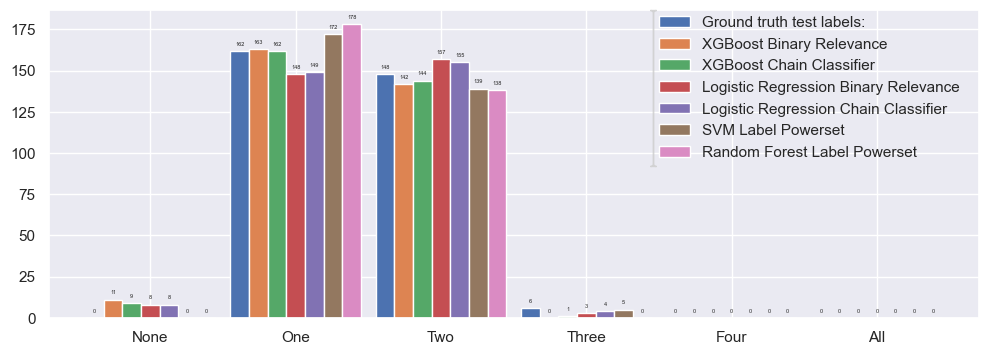

In [39]:
# Barplots for number of labels predicted
ax = plt.figure()
df_lr = pd.DataFrame({
    'Ground truth test labels:': count_number_of_labels(y_test_5perc),
    'XGBoost Binary Relevance': count_number_of_labels(xgb_br_preds),
    'XGBoost Chain Classifier': count_number_of_labels(xgb_cc_preds),
    'Logistic Regression Binary Relevance': count_number_of_labels(lr_br_preds),
    'Logistic Regression Chain Classifier': count_number_of_labels(lr_cc_preds),
    'SVM Label Powerset': count_number_of_labels(svm_lp_preds),
    'Random Forest Label Powerset': count_number_of_labels(rf_lp_preds),
    }, 
    index=['None', 'One', 'Two', 'Three', 'Four', 'All']
)
ax = df_lr.plot(kind='bar', rot=0, width = 0.9)
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'),
                (g.get_x() + g.get_width() / 2, g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points',
                fontsize=4)
plt.legend(bbox_to_anchor=(0.65, 1), ncol=1, mode="expand", borderaxespad=0)

In [25]:
xgb_br_preds

,Basal,Her2,LumA,LumB,Normal
0,0,0,1,0,0
1,0,1,0,1,0
2,0,0,0,1,0
3,0,0,1,0,1
4,0,0,1,0,1
...,...,...,...,...,...
1048,0,0,1,0,1
1049,0,0,0,0,1
1050,1,0,0,0,1
1051,0,0,1,0,1


In [28]:
# Function to set "test" or "train"
def set_test_or_train(id_value):
    if str(id_value) in test_tcga_idx.values:
        return "test"
    else:
        return "train"
    
def df_formatting(df, preds):
    df_new = df.copy()

    # Create the new column using apply()
    df_new['TRAINING OR TESTING'] =  df_new["Patient ID"].apply(set_test_or_train)
    df_new.rename(columns={'expert_PAM50_subtype': 'SUBTYPE'}, inplace=True)
    df_new['IS LUMA'] = preds['LumA'].astype('bool')
    return df_new

df_xgb_br = df_formatting(df_out_1, xgb_br_preds)
df_xgb_cc = df_formatting(df_out_1, xgb_cc_preds)
df_lr_br = df_formatting(df_out_1, lr_br_preds)
df_lr_cc = df_formatting(df_out_1, lr_cc_preds)
df_svm_lp = df_formatting(df_out_1, svm_lp_preds)
df_rf_lp = df_formatting(df_out_1, rf_lp_preds)

In [29]:
df_xgb_br

,Patient ID,SUBTYPE,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,TRAINING OR TESTING,IS LUMA
0,TCGA-3C-AAAU,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False,train,True
1,TCGA-3C-AALI,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False,test,False
2,TCGA-3C-AALJ,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False,train,False
3,TCGA-3C-AALK,LumA,NaN,NaN,LIVING,47.604958,False,False,False,False,False,test,True
4,TCGA-4H-AAAK,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False,test,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False,train,True
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False,train,False
1050,TCGA-EW-A1P7,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False,test,False
1051,TCGA-EW-A1PG,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False,test,True
